In [1]:
import os.path
import re
import sys
import tarfile
import time
import multiprocessing as mp
import itertools

import tensorflow.python.platform
from six.moves import urllib
import numpy as np
import tensorflow as tf
import h5py
import glob
import cPickle as pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.python.platform import gfile

from run_inference import predict_star, predict
import pandas as pd
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def create_graph(pb_file):
    """"Creates a graph from saved GraphDef file and returns a Graph object.
    Returns:
    Graph holding the trained Inception network.
    """
    model_filename = pb_file
    with gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')

In [3]:
#create_graph("/data/retrain_manualtags1/output_graphfinal.pb")
create_graph("/data/classify_image_graph_def.pb")
sess = tf.Session()

In [4]:
params = pickle.load(open("/data/datenet_decorations_outputs/output_params7600.pkl", 'r'))  # use 7600 for decorations; top-1 = 65.5%
fw = params["final_weights"]
fb = params["final_biases"]
print fb.shape
print fw.shape

(7,)
(2048, 7)


In [7]:
# I currently don't know what labels correspond to each of the 7 elements; will figure out

In [5]:
# from http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgb(im):
    w, h = im.shape[:2]
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = im
    ret[:, :, 1] = im
    ret[:, :, 2] = im
    return ret

# from http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgbs(im):
    n, w, h = im.shape[:3]
    ret = np.empty((n, w, h, 3), dtype=np.uint8)
    ret[:, :, :, 0] = im[:,:,:,0]
    ret[:, :, :, 1] = im[:,:,:,0]
    ret[:, :, :, 2] = im[:,:,:,0]
    return ret

# from https://gist.github.com/yusugomori/4462221
def softmax(x):
    e = np.exp(x - np.max(x))  # prevent overflow
    if e.ndim == 1:
        return e / np.sum(e, axis=0)
    else:  
        return e / np.array([np.sum(e, axis=1)]).T  # ndim = 2

In [6]:
# read in hdf5 file
image_hdf5 = h5py.File('/data/image_data.hdf5','r')
(image_metadata, book_metadata, image_to_idx) = pickle.load(open("/data/all_metadata_1M_tags.pkl", 'r'))

In [30]:
# get a list of images to look at for each date
date_to_images = {}  # each value is a dictionary with {filename --> idx}
for folder in glob.glob("/data/decorations_by_date/*/"):
    era = os.path.basename(folder[:-1])
    imgs = glob.glob(folder + "/*.jpg")
    fns = np.random.choice([os.path.basename(i)[:-4] for i in imgs], 1000, False)
    idxs = [image_to_idx[fn] for fn in fns]
    date_to_images[era] = dict(zip(fns, idxs))
print [(x, len(date_to_images[x].keys())) for x in date_to_images]

[('1870-1889', 1000), ('1750-1799', 1000), ('post-1890', 1000), ('pre-1700', 1000), ('1700-1749', 1000), ('1800-1849', 1000), ('1850-1869', 1000)]


## Pool3 and softmax

In [38]:
date_to_pool3_scores = {}
date_to_softmax_scores = {}
pool3_tensor = sess.graph.get_tensor_by_name('pool_3:0')

for era in date_to_images:
    print era
    date_to_pool3_scores[era] = {}
    date_to_softmax_scores[era] = {}

    for img in date_to_images[era]:
        idx = date_to_images[era][img]
        
        chk = idx/5000
        chunk = "Chunk" + str(chk)
        i = idx % 5000
        if chunk not in image_hdf5: continue

        a = [to_rgb(image_hdf5[chunk][i][:,:,0])]
        predictions = sess.run(pool3_tensor, {'ExpandDims:0': a})[:,0,0,:]
        date_to_pool3_scores[era][img] = predictions[0]
        
        scores = np.dot(predictions, fw) + fb
        scores = np.array([softmax(scores[j]) for j in range(scores.shape[0])])
        date_to_softmax_scores[era][img] = scores[0]

pickle.dump((date_to_pool3_scores, date_to_softmax_scores), open("/data/decorations_by_date/pool3_softmax_scores.pkl", 'w'))

1870-1889
1750-1799
post-1890
pre-1700
1700-1749
1800-1849
1850-1869


In [59]:
date_to_pool3_scores

{'1700-1749': {'002049260_0_000300_1_': array([ 0.1585463 ,  0.69297051,  0.12304182, ...,  0.20347384,
          0.02283513,  0.1269314 ], dtype=float32),
  '000308745_0_000007_1_': array([ 0.1525996 ,  0.25626445,  0.04333899, ...,  0.09573131,
          0.03679884,  0.09266222], dtype=float32),
  '001489232_0_000215_1_': array([ 0.17563885,  0.15946268,  0.08006583, ...,  0.44981536,
          0.0034972 ,  0.00789644], dtype=float32),
  '000308745_0_000357_1_': array([  6.48826838e-01,   6.80388093e-01,   2.17244506e-01, ...,
           2.78042080e-05,   6.45555481e-02,   4.20284458e-03], dtype=float32),
  '003952966_0_000035_2_': array([ 0.05645999,  0.05197226,  0.03351097, ...,  0.38777453,
          0.        ,  0.45755616], dtype=float32),
  '001379898_0_000219_1_': array([ 1.23577738,  0.86674929,  0.36077294, ...,  0.00225827,
          0.01418623,  0.        ], dtype=float32),
  '002782482_0_000217_1_': array([ 0.11187464,  0.2912609 ,  0.13547458, ...,  0.82308477,
        

In [8]:
(date_to_pool3_scores, date_to_softmax_scores) = pickle.load(open("/data/decorations_by_date/pool3_softmax_scores.pkl", 'r'))

In [12]:
len(date_to_pool3_scores["pre-1700"])

1000

In [13]:
date_to_softmax_scores["pre-1700"].keys()

['002599399_0_000012_1_',
 '002486455_0_000007_1_',
 '000241254_0_000066_1_',
 '000515955_0_000036_1_',
 '000159302_0_000008_1_',
 '001530656_0_000106_1_',
 '002417022_0_000051_2_',
 '000241254_0_000073_1_',
 '002802722_0_000194_2_',
 '000241342_0_000013_1_',
 '001509795_0_000249_1_',
 '001509795_0_000284_1_',
 '002417003_0_000011_1_',
 '002417022_0_000031_1_',
 '000805386_0_000009_1_',
 '001965168_0_000009_1_',
 '003022543_0_000007_1_',
 '000805386_0_000069_1_',
 '002599398_0_000011_1_',
 '001900865_0_000020_1_',
 '003371003_0_000008_2_',
 '003480289_0_000011_1_',
 '000241385_0_000008_1_',
 '001253016_0_000007_1_',
 '003480289_0_000013_1_',
 '003371034_0_000020_1_',
 '003194022_0_000018_3_',
 '001748776_0_000044_1_',
 '000484320_0_000011_1_',
 '000735632_0_000011_1_',
 '001746007_0_000012_1_',
 '003047017_0_000009_1_',
 '001509795_0_000250_1_',
 '000660893_0_000012_1_',
 '001248523_0_000254_1_',
 '003371081_0_000011_1_',
 '002272403_0_000011_1_',
 '002962896_0_000009_1_',
 '003840545_

In [19]:
# learn the order of labels
date_to_softmax_arr = {}
for era in date_to_softmax_scores:
    date_to_softmax_arr[era] = pd.DataFrame.from_dict(date_to_softmax_scores[era]).mean(axis=1)
date_to_softmax_arr = pd.DataFrame.from_dict(date_to_softmax_arr)
date_to_softmax_arr

1700-1749  1750-1799  1800-1849  1850-1869  1870-1889  post-1890  pre-1700
0   0.039132   0.041221   0.162318   0.437587   0.235120   0.191871  0.006641
1   0.078444   0.080790   0.528406   0.146388   0.083443   0.096569  0.011241
2   0.022062   0.013654   0.071375   0.162190   0.317262   0.211979  0.002569
3   0.083071   0.684972   0.054662   0.018775   0.009832   0.009446  0.011621
4   0.680799   0.132965   0.052746   0.019910   0.010990   0.021508  0.038627
5   0.061518   0.022232   0.010662   0.007170   0.002244   0.008356  0.923422
6   0.034974   0.024166   0.119831   0.207981   0.341109   0.460271  0.005881

In [20]:
labels = ["1850-1869", "1800-1849", "1870-1889", "1750-1799", "1700-1749", "pre-1700", "post-1890"]
labels_sorted = ["pre-1700", "1700-1749", "1750-1799", "1800-1849", "1850-1869", "1870-1889", "post-1890"]
labels_idx_pos = [labels.index(i) for i in labels_sorted]
date_to_softmax_arr = date_to_softmax_arr[labels_sorted]
date_to_softmax_arr = date_to_softmax_arr.iloc[labels_idx_pos]
date_to_softmax_arr

pre-1700  1700-1749  1750-1799  1800-1849  1850-1869  1870-1889  post-1890
5  0.923422   0.061518   0.022232   0.010662   0.007170   0.002244   0.008356
4  0.038627   0.680799   0.132965   0.052746   0.019910   0.010990   0.021508
3  0.011621   0.083071   0.684972   0.054662   0.018775   0.009832   0.009446
1  0.011241   0.078444   0.080790   0.528406   0.146388   0.083443   0.096569
0  0.006641   0.039132   0.041221   0.162318   0.437587   0.235120   0.191871
2  0.002569   0.022062   0.013654   0.071375   0.162190   0.317262   0.211979
6  0.005881   0.034974   0.024166   0.119831   0.207981   0.341109   0.460271

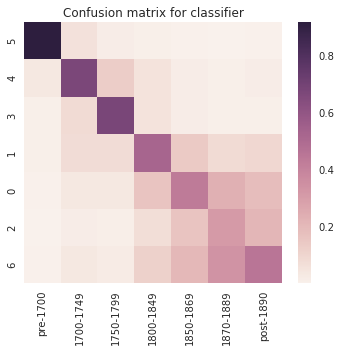

In [78]:
plt.figure(figsize=[5,5])
sns.heatmap(date_to_softmax_arr)  # we can see that the closer the dates the more likely things are to cluster
plt.title("Confusion matrix for classifier")
plt.tight_layout()
plt.savefig("neuron_pics/decor_confusion_matrix.png")

In [22]:
# heatmap it, rank neurons from low->high to high->low
date_to_pool3_arr = {}
for era in date_to_softmax_scores:
    date_to_pool3_arr[era] = pd.DataFrame.from_dict(date_to_pool3_scores[era]).mean(axis=1)
date_to_pool3_arr = pd.DataFrame.from_dict(date_to_pool3_arr)
date_to_pool3_arr = date_to_pool3_arr[labels_sorted]

In [23]:
# Luda: Get Images with the top activations for each neuron
# Data structure: array of neurons, each is an array of image_name:tag pairs with the highest activations from the pool-3layer
import operator

def get_top_activations(activations, num_neurons, k, top=True):
    res = []
    for i in range(0, num_neurons):
        all_activations = {}
        #get top image_name:tag pairs for each neuron 
        for era in activations:
            for img_name in activations[era]:
                scores = activations[era][img_name]
                all_activations[(img_name, era)] = scores[i]
        res.append(sorted(all_activations.items(), key=operator.itemgetter(1), reverse=top)[:k])
    return res

top_images = get_top_activations(date_to_pool3_scores, 2048, 5)
bottom_images = get_top_activations(date_to_pool3_scores, 2048, 5, top=False)
print top_images[:5]
print bottom_images[:5]

[[(('002167334_11_000026_3_', 'post-1890'), 2.0299096), (('001613136_0_000332_1_', '1870-1889'), 1.859188), (('002802722_0_000172_1_', 'pre-1700'), 1.6408042), (('000795252_0_000354_1_', '1800-1849'), 1.634481), (('002802722_0_000127_1_', 'pre-1700'), 1.6257583)], [(('001972297_07_000051_1_', 'post-1890'), 2.025769), (('002150812_0_000538_1_', '1850-1869'), 1.7858142), (('003520629_02_000079_1_', '1800-1849'), 1.6622168), (('003759501_0_000126_1_', 'post-1890'), 1.4863414), (('003990028_0_000284_1_', '1870-1889'), 1.4081345)], [(('003870771_0_000197_1_', '1800-1849'), 0.97694707), (('003525289_0_000009_1_', '1750-1799'), 0.93012911), (('001142504_01_000206_1_', '1800-1849'), 0.91762745), (('000404520_0_000012_1_', '1870-1889'), 0.88129115), (('000366784_0_000176_1_', '1750-1799'), 0.84955096)], [(('002121080_0_000218_1_', '1870-1889'), 1.3252484), (('001959398_0_000109_1_', 'post-1890'), 1.2960569), (('003222432_01_000198_1_', '1870-1889'), 1.1247065), (('004159563_05_000154_2_', '1800

In [43]:
#plt.subplots(6,2)

def plot_top_bottom(neuron, fn):
    plt.figure(figsize=[15,6])
    for ctr in range(5):
        info = top_images[neuron][ctr]
        img = info[0][0]
        era = info[0][1]
        idx = image_to_idx[img]

        chk = idx/5000
        chunk = "Chunk" + str(chk)
        i = idx % 5000
        if chunk not in image_hdf5: continue

        plt.subplot(2,5,ctr+1)
        plt.imshow(image_hdf5[chunk][i][:,:,0], cmap=mpl.cm.gray)
        plt.title(info[1])
        plt.axis('off')
    for ctr in range(5):
        info = bottom_images[neuron][ctr]
        img = info[0][0]
        era = info[0][1]
        idx = image_to_idx[img]

        chk = idx/5000
        chunk = "Chunk" + str(chk)
        i = idx % 5000
        if chunk not in image_hdf5: continue

        plt.subplot(2,5,ctr+6)
        plt.imshow(image_hdf5[chunk][i][:,:,0], cmap=mpl.cm.gray)
        plt.title(info[1])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(fn)
    plt.show()

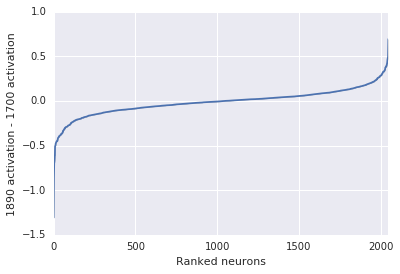

In [69]:
diff = date_to_pool3_arr["post-1890"] - date_to_pool3_arr["pre-1700"]
diff.sort_values(inplace=True)
sns.tsplot(diff)
plt.xlabel("Ranked neurons")
plt.ylabel("1890 activation - 1700 activation")
plt.savefig("neuron_pics/decor_mix10_rank.png")

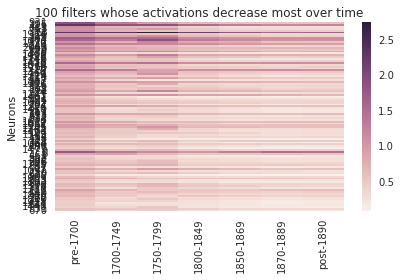

In [85]:
sns.heatmap(date_to_pool3_arr.iloc[diff.index[:100]])
plt.title("100 filters whose activations decrease most over time")
plt.ylabel("Neurons")
plt.tight_layout()
plt.savefig("neuron_pics/decor_mix10_down_heatmap.png")

In [26]:
date_to_pool3_arr.iloc[diff.index[:5]]

pre-1700  1700-1749  1750-1799  1800-1849  1850-1869  1870-1889  \
931  1.888131   1.325364   0.967477   0.682856   0.579481   0.577527   
195  2.293038   1.880360   1.878607   1.550050   1.338016   1.192686   
419  1.139803   0.682876   0.651735   0.398961   0.305353   0.290194   
763  1.082676   0.830684   1.016860   0.525038   0.376804   0.314085   
951  1.154896   0.726793   0.569372   0.501456   0.492550   0.518386   

     post-1890  
931   0.581462  
195   1.229717  
419   0.281249  
763   0.331665  
951   0.467782

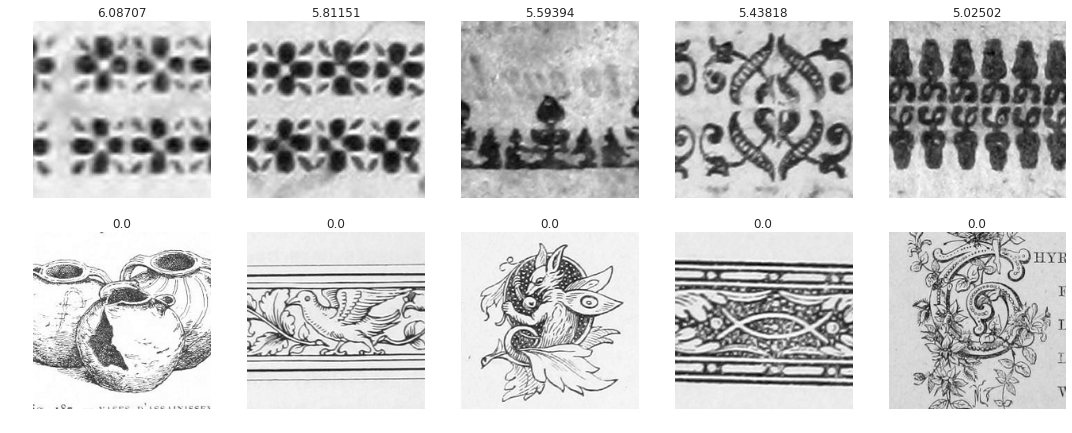

In [46]:
plot_top_bottom(931, "neuron_pics/decor_neuron931_down.png")

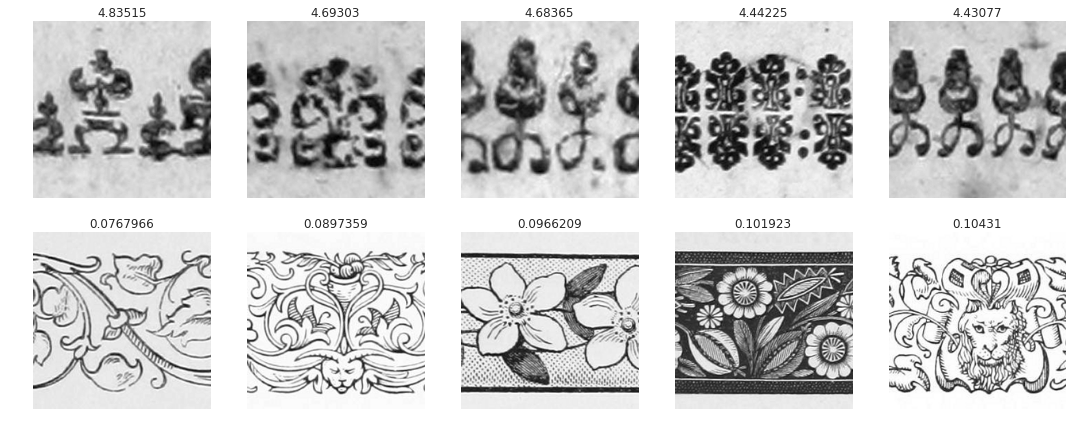

In [47]:
plot_top_bottom(195, "neuron_pics/decor_neuron195_down.png")

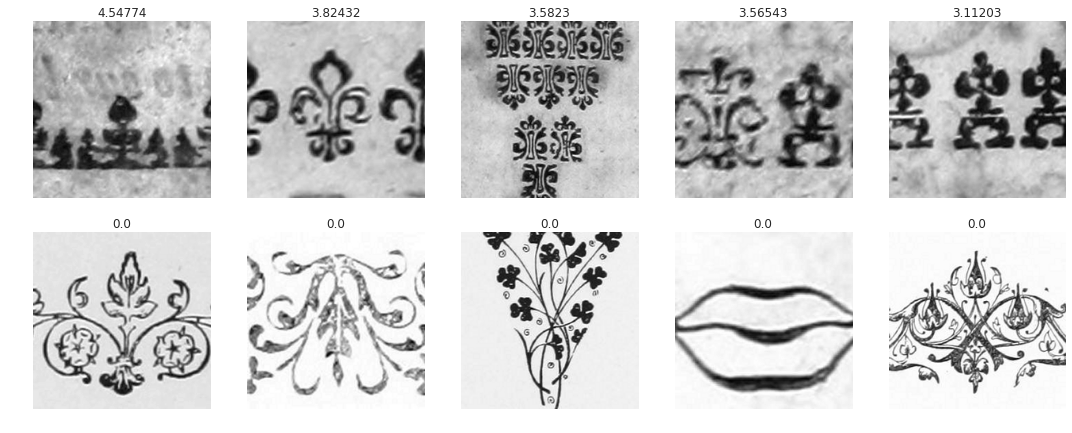

In [48]:
plot_top_bottom(419, "neuron_pics/decor_neuron419_down.png")

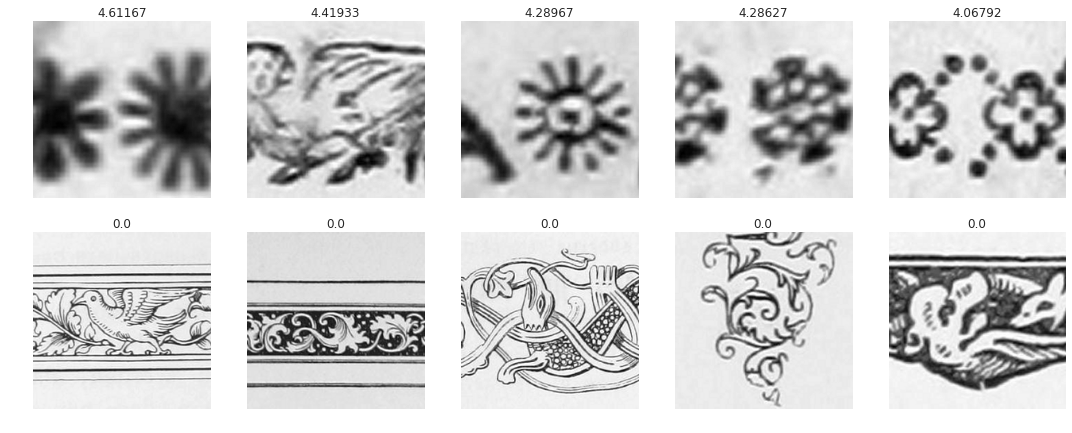

In [49]:
plot_top_bottom(763, "neuron_pics/decor_neuron763_down.png")

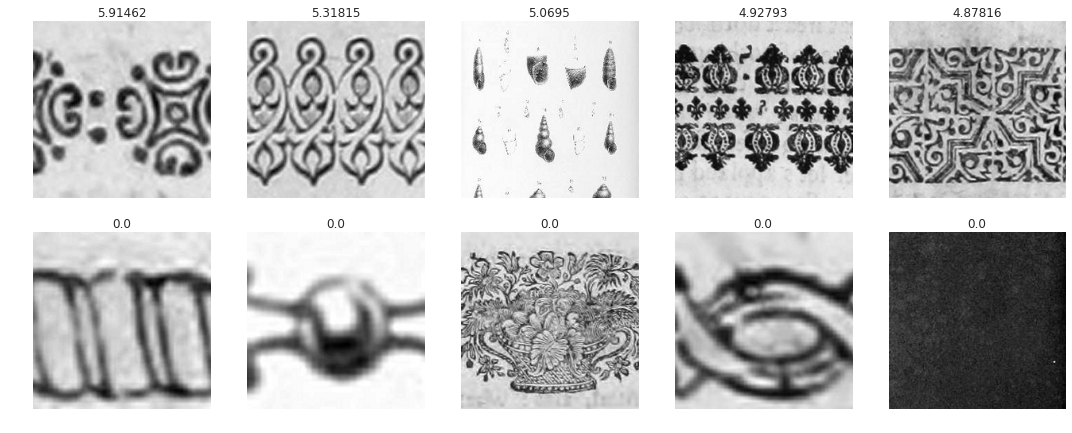

In [50]:
plot_top_bottom(951, "neuron_pics/decor_neuron951_down.png")

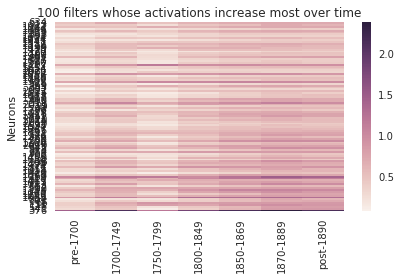

In [84]:
sns.heatmap(date_to_pool3_arr.iloc[diff.index[-100:]])
plt.title("100 filters whose activations increase most over time")
plt.ylabel("Neurons")
plt.tight_layout()
plt.savefig("neuron_pics/decor_mix10_up_heatmap.png")

In [83]:
date_to_pool3_arr.iloc[diff.index[-5:]]

pre-1700  1700-1749  1750-1799  1800-1849  1850-1869  1870-1889  \
66   0.409132   0.716593   0.916283   0.841083   0.870123   0.880397   
11   0.404151   0.650432   0.814286   0.762257   0.917762   0.978023   
126  0.343460   0.497795   0.235274   0.457614   0.603215   0.830672   
541  0.285812   0.456036   0.128858   0.410659   0.635929   0.851639   
376  1.470577   2.134178   1.214491   1.828239   2.172730   2.405102   

     post-1890  
66    0.885531  
11    0.894662  
126   0.839081  
541   0.886203  
376   2.163369

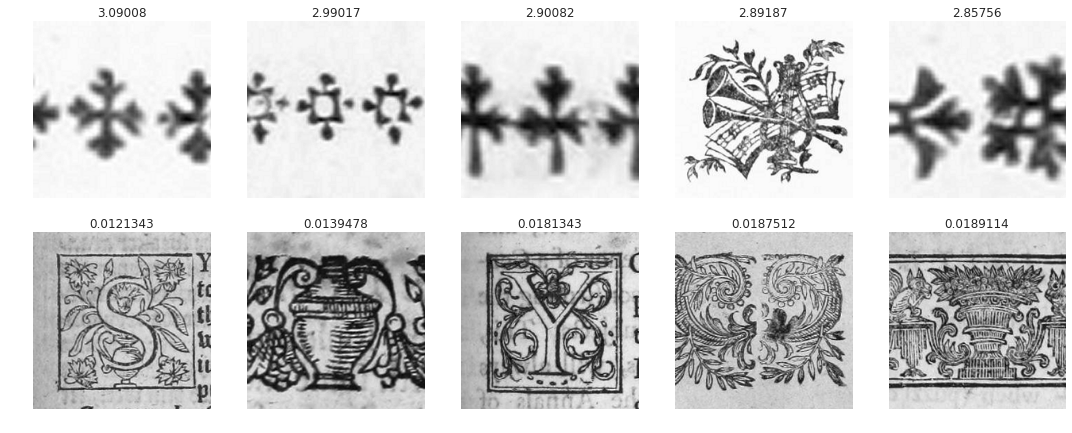

In [64]:
plot_top_bottom(66, "neuron_pics/decor_neuron66_up.png")

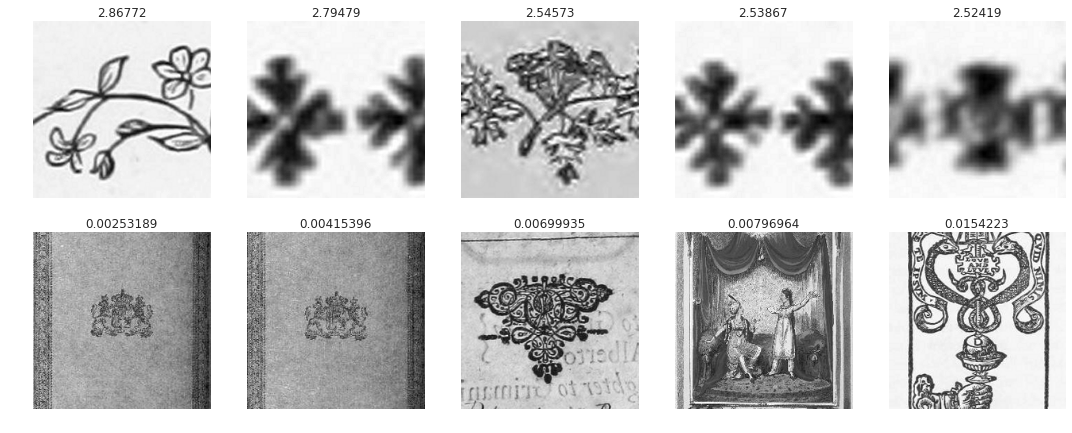

In [65]:
plot_top_bottom(11, "neuron_pics/decor_neuron11_up.png")

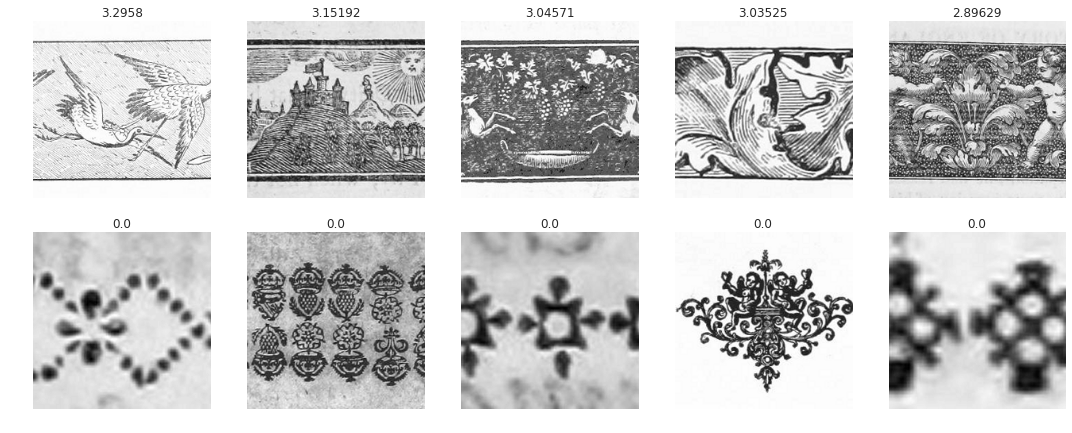

In [66]:
plot_top_bottom(126, "neuron_pics/decor_neuron126_up.png")

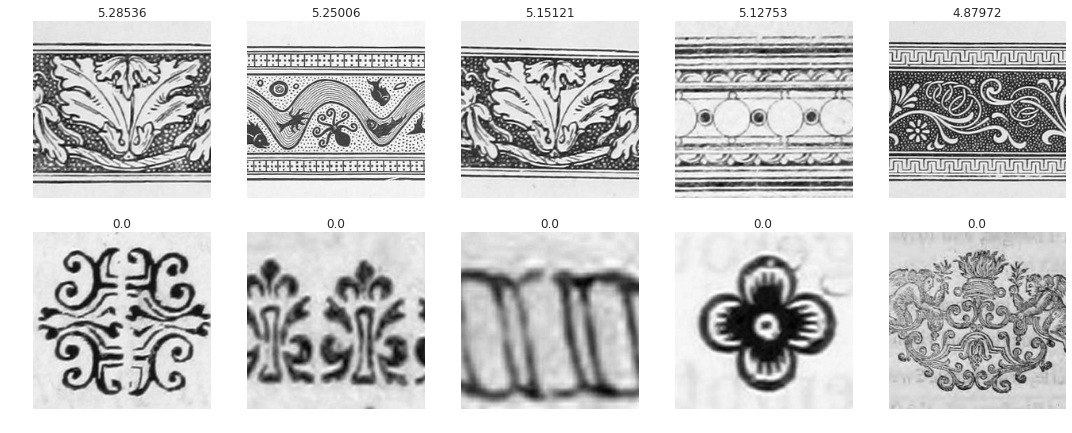

In [67]:
plot_top_bottom(541, "neuron_pics/decor_neuron541_up.png")

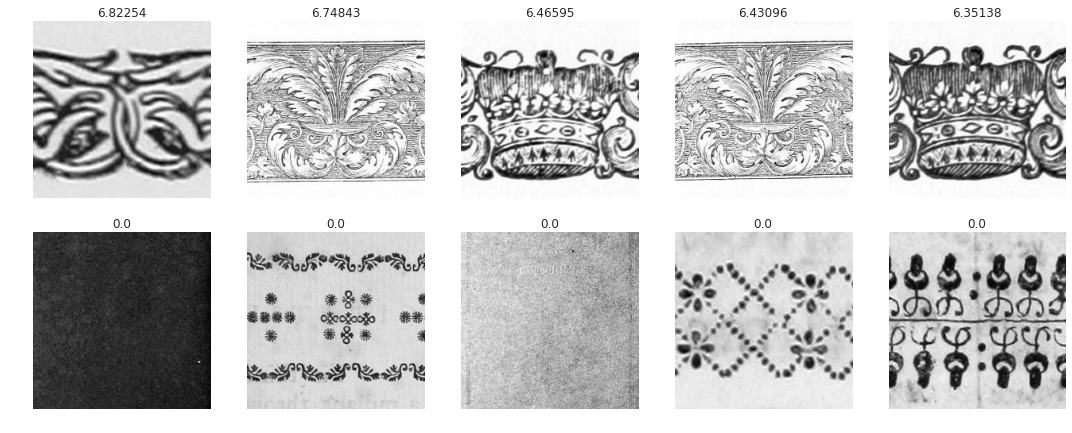

In [68]:
plot_top_bottom(376, "neuron_pics/decor_neuron376_up.png")

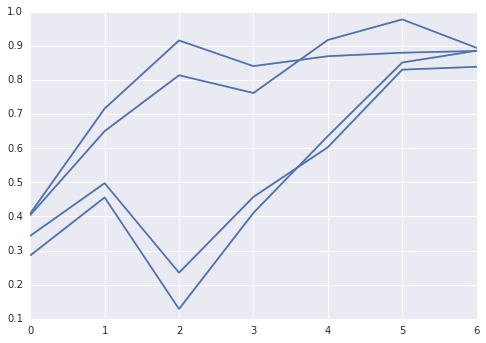

In [90]:
# another way to look at trends

sns.tsplot(date_to_pool3_arr.iloc[diff.index[-5:]].iloc[0])
sns.tsplot(date_to_pool3_arr.iloc[diff.index[-5:]].iloc[1])
sns.tsplot(date_to_pool3_arr.iloc[diff.index[-5:]].iloc[2])
sns.tsplot(date_to_pool3_arr.iloc[diff.index[-5:]].iloc[3])

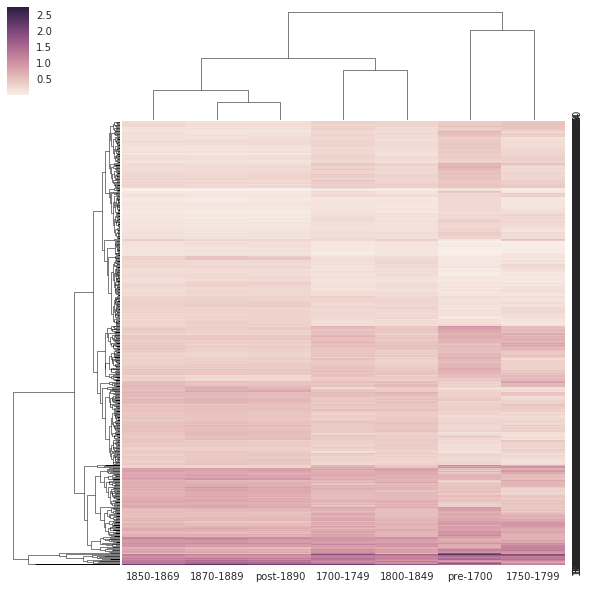

In [106]:
# can do clustering so that we can see which neurons are most activated for each era
date_to_pool3_arr_sig = pd.concat((date_to_pool3_arr.iloc[diff.index[-300:]], date_to_pool3_arr.iloc[diff.index[:300]]))
sns.clustermap(date_to_pool3_arr_sig)

## Layer 0

In [107]:
# what other layers are there that we could look at?

# reconstruct date_to_images
date_to_images = {}
for era in date_to_softmax_scores:
    date_to_images[era] = {}
    for img in date_to_softmax_scores[era]:
        idx = image_to_idx[img]
        date_to_images[era][img] = idx

In [80]:
date_to_conv0_scores = {}
conv0_tensor = sess.graph.get_tensor_by_name('conv:0')

for era in date_to_images:
    print era
    date_to_conv0_scores[era] = {}

    for img in date_to_images[era]:
        idx = date_to_images[era][img]
        
        chk = idx/5000
        chunk = "Chunk" + str(chk)
        i = idx % 5000
        if chunk not in image_hdf5: continue

        a = [to_rgb(image_hdf5[chunk][i][:,:,0])]
        predictions = sess.run(conv0_tensor, {'ExpandDims:0': a})
        date_to_conv0_scores[era][img] = predictions.sum(axis=(0,1,2))

pickle.dump(date_to_conv0_scores, open("/data/decorations_by_date/conv0_scores.pkl", 'w'))

1870-1889
1750-1799
post-1890
pre-1700
1700-1749
1800-1849
1850-1869


In [122]:
conv0_tensor.eval(session=sess).shape

(1, 149, 149, 32)

In [128]:
date_to_conv0_scores['1870-1889']['000359422_0_000208_4_'].shape

(32,)

In [81]:
# heatmap it, rank neurons from low->high to high->low
date_to_conv0_scores = pickle.load(open("/data/decorations_by_date/conv0_scores.pkl", 'r'))
date_to_conv0_arr = {}
for era in date_to_conv0_scores:
    date_to_conv0_arr[era] = pd.DataFrame.from_dict(date_to_conv0_scores[era]).mean(axis=1)
date_to_conv0_arr = pd.DataFrame.from_dict(date_to_conv0_arr)
date_to_conv0_arr = date_to_conv0_arr[labels_sorted]

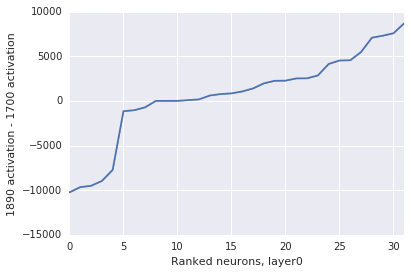

In [82]:
diff_conv0 = date_to_conv0_arr["post-1890"] - date_to_conv0_arr["pre-1700"]
diff_conv0.sort_values(inplace=True)
sns.tsplot(diff_conv0)
plt.xlabel("Ranked neurons, layer0")
plt.ylabel("1890 activation - 1700 activation")

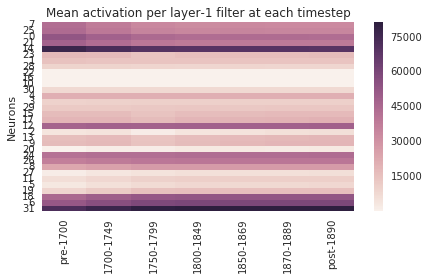

In [86]:
sns.heatmap(date_to_conv0_arr.ix[diff_conv0.index])
plt.title("Mean activation per layer-1 filter at each timestep")
plt.tight_layout()
plt.ylabel("Neurons")
plt.savefig("neuron_pics/decor_conv0_up_heatmap.png")

## Conv 4

In [137]:
date_to_conv4_scores = {}
conv4_tensor = sess.graph.get_tensor_by_name('conv_4:0')

for era in date_to_images:
    print era
    date_to_conv4_scores[era] = {}

    for img in date_to_images[era]:
        idx = date_to_images[era][img]
        
        chk = idx/5000
        chunk = "Chunk" + str(chk)
        i = idx % 5000
        if chunk not in image_hdf5: continue

        a = [to_rgb(image_hdf5[chunk][i][:,:,0])]
        predictions = sess.run(conv4_tensor, {'ExpandDims:0': a})
        date_to_conv4_scores[era][img] = predictions.sum(axis=(0,1,2))

pickle.dump(date_to_conv4_scores, open("/data/decorations_by_date/conv4_scores.pkl", 'w'))

1870-1889
1750-1799
post-1890
pre-1700
1700-1749
1800-1849
1850-1869


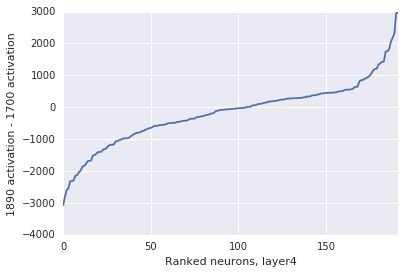

In [91]:
date_to_conv4_scores = pickle.load(open("/data/decorations_by_date/conv4_scores.pkl", 'r'))
date_to_conv4_arr = {}
for era in date_to_conv0_scores:
    date_to_conv4_arr[era] = pd.DataFrame.from_dict(date_to_conv4_scores[era]).mean(axis=1)
date_to_conv4_arr = pd.DataFrame.from_dict(date_to_conv4_arr)
date_to_conv4_arr = date_to_conv4_arr[labels_sorted]
diff_conv4 = date_to_conv4_arr["post-1890"] - date_to_conv4_arr["pre-1700"]
diff_conv4.sort_values(inplace=True)
sns.tsplot(diff_conv4)
plt.xlabel("Ranked neurons, layer4")
plt.ylabel("1890 activation - 1700 activation")

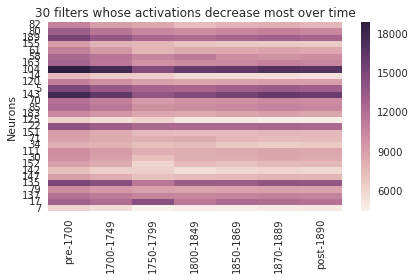

In [93]:
# heatmap it, rank neurons from low->high to high->low

sns.heatmap(date_to_conv4_arr.ix[diff_conv4.index[:30]])
plt.ylabel("Neurons")
plt.title("30 filters whose activations decrease most over time")
plt.tight_layout()
plt.savefig("neuron_pics/decor_conv4_down_heatmap.png")

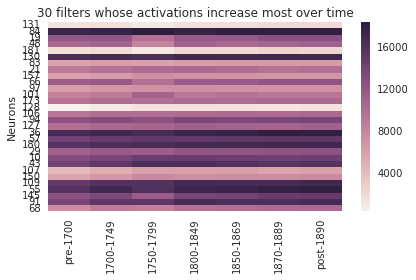

In [94]:
sns.heatmap(date_to_conv4_arr.ix[diff_conv4.index[-30:]])
plt.ylabel("Neurons")
plt.title("30 filters whose activations increase most over time")
plt.tight_layout()
plt.savefig("neuron_pics/decor_conv4_up_heatmap.png")

## Mixed 5

In [98]:
date_to_mix5_scores = {}
mix5_tensor = sess.graph.get_tensor_by_name('mixed_5/join:0')

for era in date_to_images:
    print era
    date_to_mix5_scores[era] = {}

    for img in date_to_images[era]:
        idx = date_to_images[era][img]
        
        chk = idx/5000
        chunk = "Chunk" + str(chk)
        i = idx % 5000
        if chunk not in image_hdf5: continue

        a = [to_rgb(image_hdf5[chunk][i][:,:,0])]
        predictions = sess.run(mix5_tensor, {'ExpandDims:0': a})
        date_to_mix5_scores[era][img] = predictions.sum(axis=(0,1,2))

pickle.dump(date_to_mix5_scores, open("/data/decorations_by_date/mix5_scores.pkl", 'w'))

1870-1889
1750-1799
post-1890
pre-1700
1700-1749
1800-1849
1850-1869


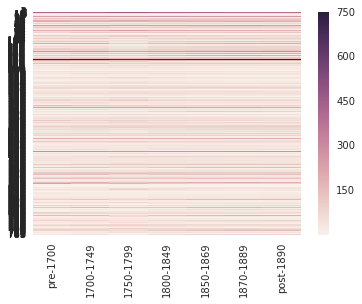

In [99]:
# heatmap it, rank neurons from low->high to high->low
date_to_mix5_scores = pickle.load(open("/data/decorations_by_date/mix5_scores.pkl", 'r'))

date_to_mix5_arr = {}
for era in date_to_conv0_scores:
    date_to_mix5_arr[era] = pd.DataFrame.from_dict(date_to_mix5_scores[era]).mean(axis=1)
date_to_mix5_arr = pd.DataFrame.from_dict(date_to_mix5_arr)
date_to_mix5_arr = date_to_mix5_arr[labels_sorted]
diff_mix5 = date_to_mix5_arr["post-1890"] - date_to_mix5_arr["pre-1700"]
diff_mix5.sort_values(inplace=True)
sns.heatmap(date_to_mix5_arr)

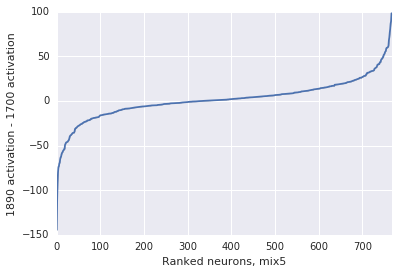

In [100]:
sns.tsplot(diff_mix5)
plt.xlabel("Ranked neurons, mix5")
plt.ylabel("1890 activation - 1700 activation")

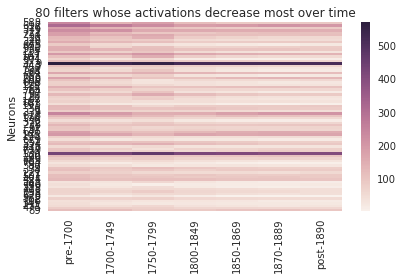

In [103]:
sns.heatmap(date_to_mix5_arr.ix[diff_mix5.index[:80]])
plt.ylabel("Neurons")
plt.title("80 filters whose activations decrease most over time")
plt.tight_layout()
plt.savefig("neuron_pics/decor_mix5_down_heatmap.png")

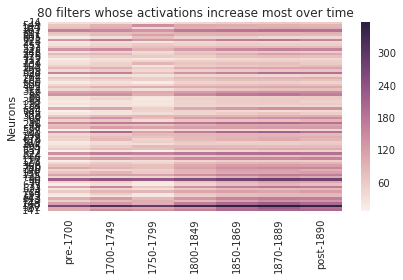

In [104]:
sns.heatmap(date_to_mix5_arr.ix[diff_mix5.index[-80:]])
plt.ylabel("Neurons")
plt.title("80 filters whose activations increase most over time")
plt.tight_layout()
plt.savefig("neuron_pics/decor_mix5_up_heatmap.png")

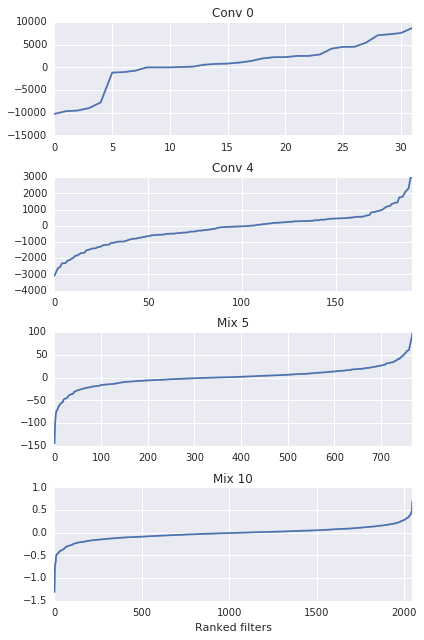

In [105]:
plt.figure(figsize=[6,9])
plt.subplot(411)
plt.title("Conv 0")
sns.tsplot(diff_conv0)
plt.subplot(412)
sns.tsplot(diff_conv4)
plt.title("Conv 4")
plt.subplot(413)
sns.tsplot(diff_mix5)
plt.title("Mix 5")
plt.subplot(414)
sns.tsplot(diff)
plt.title("Mix 10")
plt.xlabel("Ranked filters")
plt.tight_layout()
plt.savefig("neuron_pics/decor_all_ranks.png")